# Cross-Region Comparison: Thalamus vs Claustrum vs Lateral Habenula

This notebook compares neuromodulator receptor expression across **three diencephalic/
claustral regions** to identify conserved versus region-specific patterns.

### Comparisons
1. **Intra-thalamic**: Nucleus-specific receptor profiles (MD, PVT, RT, anterior TH, etc.)
2. **TH vs CLA**: Shared glia/non-neuronal types between thalamus and claustrum
3. **LHb vs TH relay**: Habenula-specific vs thalamic relay glutamatergic neurons
4. **CLA excitatory vs TH excitatory**: Claustral projection neurons vs thalamic relay neurons

### Data Sources
- MERFISH: TH (50K cells, 15 nuclei), CLA+EPd (11K cells), LHb (2.5K cells)
- 10x: TH (261K cells), CLA (29K cells)
- All 11 MERFISH genes for spatial comparisons, 28 genes for 10x

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import seaborn as sns
import re

## 1. Load All MERFISH Data

In [2]:
def strip_prefix(name):
    return re.sub(r'^\d+\s+', '', str(name))

shared_genes = ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7',
                'Adra1a', 'Adra1b',
                'Drd1', 'Drd2', 'Drd3', 'Drd5']

# TH MERFISH
th_mer_expr = pd.read_csv('th_merfish_expression.csv', index_col=0)
th_mer_meta = pd.read_csv('th_merfish_metadata.csv', index_col=0)
th_mer_meta['subclass_short'] = th_mer_meta['subclass'].apply(strip_prefix)

# CLA MERFISH
cla_mer_expr = pd.read_csv('cla_merfish_expression.csv', index_col=0)
cla_mer_meta = pd.read_csv('cla_merfish_metadata.csv', index_col=0)
cla_mer_meta['subclass_short'] = cla_mer_meta['subclass'].apply(strip_prefix)

# LHb MERFISH
lhb_mer_expr = pd.read_csv('lhb_merfish_expression.csv', index_col=0)
lhb_mer_meta = pd.read_csv('lhb_merfish_metadata.csv', index_col=0)
lhb_mer_meta['subclass_short'] = lhb_mer_meta['subclass'].apply(strip_prefix)

# TH 10x
th_10x_expr = pd.read_csv('th_10x_expression.csv', index_col=0)
th_10x_meta = pd.read_csv('th_10x_metadata.csv', index_col=0)
th_10x_meta['subclass_short'] = th_10x_meta['subclass'].apply(strip_prefix)

# CLA 10x
cla_10x_neur = pd.read_csv('cla_10x_neuronal_expression.csv', index_col=0)
cla_10x_glia = pd.read_csv('cla_10x_glia_expression.csv', index_col=0)
cla_10x_expr = pd.concat([cla_10x_neur, cla_10x_glia])
cla_10x_meta = pd.read_csv('cla_10x_metadata.csv', index_col=0)
cla_10x_meta['subclass_short'] = cla_10x_meta['subclass'].apply(strip_prefix)

print('Loaded:')
print(f'  TH MERFISH:  {len(th_mer_expr):,} cells')
print(f'  CLA MERFISH: {len(cla_mer_expr):,} cells')
print(f'  LHb MERFISH: {len(lhb_mer_expr):,} cells')
print(f'  TH 10x:     {len(th_10x_expr):,} cells')
print(f'  CLA 10x:    {len(cla_10x_expr):,} cells')

Loaded:
  TH MERFISH:  50,282 cells
  CLA MERFISH: 8,932 cells
  LHb MERFISH: 2,486 cells
  TH 10x:     259,327 cells
  CLA 10x:    53,972 cells


## 2. Intra-Thalamic Nucleus Comparison (MERFISH)

Compare receptor expression between functional groups of thalamic nuclei:
- **Mediodorsal (MD)**: Association/prefrontal thalamus
- **Midline (PVT, CM, IMD)**: Arousal/stress/visceral
- **Anterior (AD, AV, AM)**: Spatial navigation/memory
- **Reticular (RT)**: GABAergic gating
- **Intralaminar (PF, CL, PCN)**: Arousal/pain

In [3]:
# Group nuclei by functional category
nucleus_groups = {
    'MD': ['MD'],
    'Midline': ['PVT', 'CM', 'IMD'],
    'Anterior': ['AD', 'AV', 'AM', 'IAD', 'IAM'],
    'Reticular': ['RT'],
    'Intralaminar': ['PF', 'CL', 'PCN'],
    'Reuniens': ['RE', 'Xi']
}

# Compute per-nucleus-group mean expression for neuronal cells only
common = th_mer_expr.index.intersection(th_mer_meta.index)
th_expr = th_mer_expr.loc[common, shared_genes].copy()
th_meta = th_mer_meta.loc[common].copy()

# Filter to neuronal cells (exclude NN suffix = non-neuronal)
neuronal_mask = ~th_meta['subclass_short'].str.endswith(' NN')
th_expr_neur = th_expr[neuronal_mask]
th_meta_neur = th_meta[neuronal_mask]

# Create nucleus group column
def assign_group(structure):
    for group, nuclei in nucleus_groups.items():
        if structure in nuclei:
            return group
    return 'Other'

th_meta_neur['nucleus_group'] = th_meta_neur['parcellation_structure'].apply(assign_group)
th_expr_neur['nucleus_group'] = th_meta_neur['nucleus_group'].values

# Remove 'Other'
mask = th_expr_neur['nucleus_group'] != 'Other'
th_expr_neur = th_expr_neur[mask]

group_mean = th_expr_neur.groupby('nucleus_group')[shared_genes].mean()
group_frac = th_expr_neur.groupby('nucleus_group')[shared_genes].apply(lambda x: (x > 0).mean())
group_counts = th_expr_neur.groupby('nucleus_group').size()

print('Nucleus groups (neuronal cells only):')
for grp in ['MD', 'Midline', 'Anterior', 'Reticular', 'Intralaminar', 'Reuniens']:
    if grp in group_counts.index:
        print(f'  {grp:15s}: {group_counts[grp]:>6,} cells')

print('\nMean expression by nucleus group:')
display(group_mean.round(3))
print('\nFraction expressing by nucleus group:')
display(group_frac.round(3))

Nucleus groups (neuronal cells only):
  MD             :  5,609 cells
  Midline        :  5,128 cells
  Anterior       :  4,718 cells
  Reticular      :  6,931 cells
  Intralaminar   :  4,044 cells
  Reuniens       :  2,125 cells

Mean expression by nucleus group:


/tmp/ipykernel_2583/719294315.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  th_meta_neur['nucleus_group'] = th_meta_neur['parcellation_structure'].apply(assign_group)
/tmp/ipykernel_2583/719294315.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  th_expr_neur['nucleus_group'] = th_meta_neur['nucleus_group'].values


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
nucleus_group,,,,,,,,,,,
Anterior,0.335,0.044,0.289,0.075,0.632,0.077,1.025,0.392,0.508,0.207,0.253
Intralaminar,0.313,0.077,0.102,0.097,1.433,0.061,0.969,0.048,0.339,0.220,0.596
MD,0.239,0.084,0.086,0.031,0.790,0.059,1.731,0.077,0.621,0.202,0.366
Midline,0.529,0.342,0.110,0.043,1.264,0.116,1.400,0.357,0.816,0.673,0.530
Reticular,0.141,0.119,0.151,0.033,0.114,0.098,1.258,0.131,0.079,0.150,0.164
Reuniens,0.734,0.161,0.132,0.067,1.805,0.095,0.807,0.462,0.300,0.241,0.941



Fraction expressing by nucleus group:


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
nucleus_group,,,,,,,,,,,
Anterior,0.287,0.054,0.211,0.083,0.483,0.086,0.694,0.292,0.430,0.175,0.202
Intralaminar,0.267,0.094,0.117,0.108,0.705,0.069,0.549,0.053,0.275,0.202,0.396
MD,0.215,0.098,0.103,0.039,0.553,0.070,0.860,0.080,0.434,0.175,0.266
Midline,0.409,0.281,0.121,0.050,0.735,0.126,0.757,0.255,0.488,0.424,0.366
Reticular,0.141,0.130,0.144,0.037,0.124,0.102,0.730,0.139,0.082,0.163,0.159
Reuniens,0.522,0.166,0.142,0.079,0.873,0.108,0.571,0.289,0.282,0.203,0.594


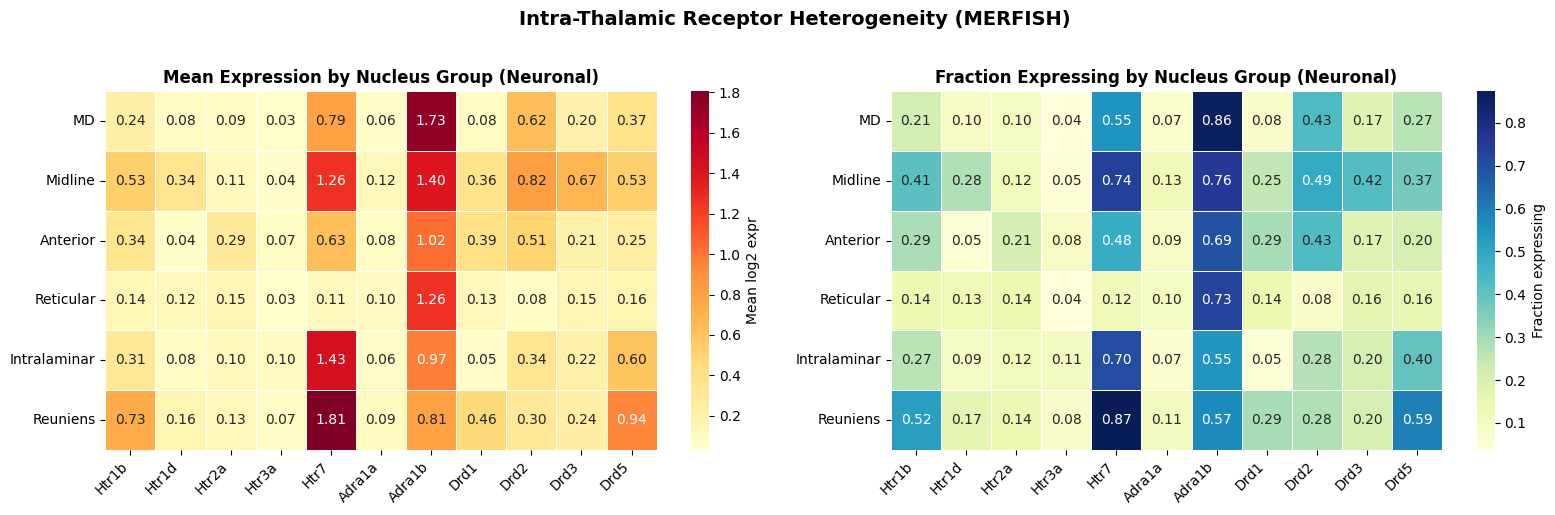

Saved: xregion_thalamic_nucleus_heatmap.png


In [4]:
# Heatmap of nucleus-group receptor enrichment
group_order = ['MD', 'Midline', 'Anterior', 'Reticular', 'Intralaminar', 'Reuniens']
group_order = [g for g in group_order if g in group_frac.index]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Mean expression heatmap
sns.heatmap(group_mean.loc[group_order], annot=True, fmt='.2f', cmap='YlOrRd',
            ax=axes[0], linewidths=0.5, cbar_kws={'label': 'Mean log2 expr'})
axes[0].set_title('Mean Expression by Nucleus Group (Neuronal)', fontweight='bold')
axes[0].set_ylabel('')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Fraction expressing heatmap
sns.heatmap(group_frac.loc[group_order], annot=True, fmt='.2f', cmap='YlGnBu',
            ax=axes[1], linewidths=0.5, cbar_kws={'label': 'Fraction expressing'})
axes[1].set_title('Fraction Expressing by Nucleus Group (Neuronal)', fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Intra-Thalamic Receptor Heterogeneity (MERFISH)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('xregion_thalamic_nucleus_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: xregion_thalamic_nucleus_heatmap.png')

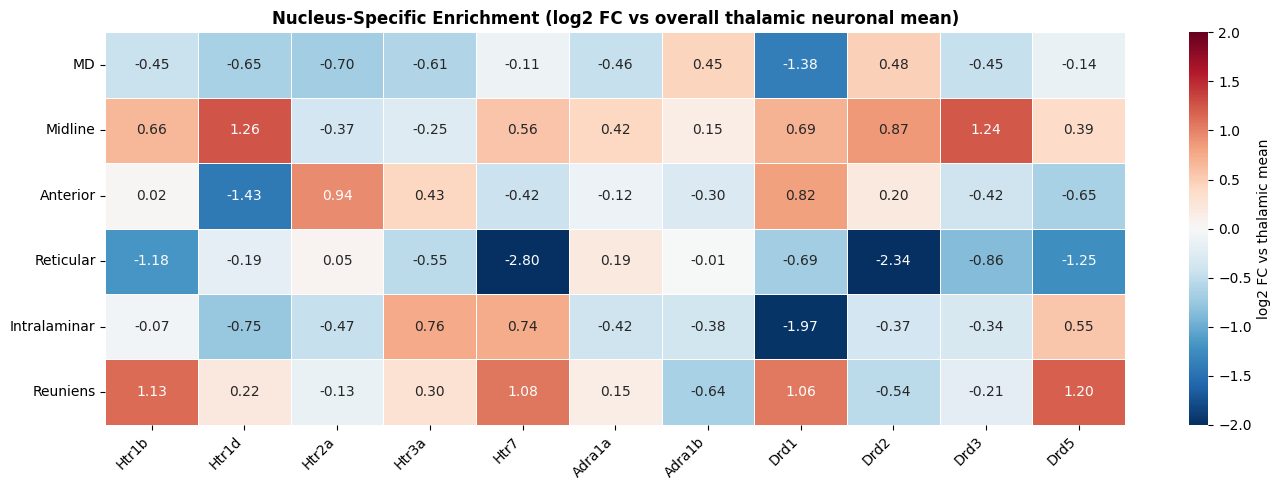

Saved: xregion_thalamic_enrichment.png

Key enrichments (|log2FC| > 0.5):
  MD              Htr1d   : -0.65 (depleted)
  MD              Htr2a   : -0.70 (depleted)
  MD              Htr3a   : -0.61 (depleted)
  MD              Drd1    : -1.38 (depleted)
  Midline         Htr1b   : +0.66 (enriched)
  Midline         Htr1d   : +1.26 (enriched)
  Midline         Htr7    : +0.56 (enriched)
  Midline         Drd1    : +0.69 (enriched)
  Midline         Drd2    : +0.87 (enriched)
  Midline         Drd3    : +1.24 (enriched)
  Anterior        Htr1d   : -1.43 (depleted)
  Anterior        Htr2a   : +0.94 (enriched)
  Anterior        Drd1    : +0.82 (enriched)
  Anterior        Drd5    : -0.65 (depleted)
  Reticular       Htr1b   : -1.18 (depleted)
  Reticular       Htr3a   : -0.55 (depleted)
  Reticular       Htr7    : -2.80 (depleted)
  Reticular       Drd1    : -0.69 (depleted)
  Reticular       Drd2    : -2.34 (depleted)
  Reticular       Drd3    : -0.86 (depleted)
  Reticular       Drd5    

In [5]:
# Log2 fold-change relative to overall thalamic mean (neuronal)
overall_mean = th_expr_neur[shared_genes].mean()
pseudocount = 0.01
log2fc = np.log2((group_mean + pseudocount) / (overall_mean + pseudocount))

fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(log2fc.loc[group_order], annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            ax=ax, linewidths=0.5, vmin=-2, vmax=2,
            cbar_kws={'label': 'log2 FC vs thalamic mean'})
ax.set_title('Nucleus-Specific Enrichment (log2 FC vs overall thalamic neuronal mean)',
             fontweight='bold')
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig('xregion_thalamic_enrichment.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: xregion_thalamic_enrichment.png')

print('\nKey enrichments (|log2FC| > 0.5):')
for grp in group_order:
    for gene in shared_genes:
        fc = log2fc.loc[grp, gene]
        if abs(fc) > 0.5:
            direction = 'enriched' if fc > 0 else 'depleted'
            print(f'  {grp:15s} {gene:8s}: {fc:+.2f} ({direction})')

## 3. LHb vs Thalamic Relay Neurons (MERFISH)

Compare the LHb-specific glutamatergic population (LH Pou4f1 Sox1 Glut)
with major thalamic glutamatergic subclasses to highlight habenula uniqueness.

In [6]:
# Get LHb neuronal cells
lhb_common = lhb_mer_expr.index.intersection(lhb_mer_meta.index)
lhb_expr = lhb_mer_expr.loc[lhb_common, shared_genes].copy()
lhb_meta = lhb_mer_meta.loc[lhb_common].copy()

# Focus on the main LHb glutamatergic subclass
lhb_glut_mask = lhb_meta['subclass_short'] == 'LH Pou4f1 Sox1 Glut'
lhb_glut_expr = lhb_expr[lhb_glut_mask]

# Get major TH glutamatergic subclasses from MERFISH
th_glut_subclasses = [
    'TH Prkcd Grin2c Glut',
    'PVT-PT Ntrk1 Glut',
    'CM-IAD-CL-PCN Sema5b Glut',
    'AD Serpinb7 Glut',
    'PF Fzd5 Glut',
    'RE-Xi Nox4 Glut',
    'RT-ZI Gnb3 Gaba'
]

# Build comparison DataFrame
comparison_data = []

# LHb
lhb_mean = lhb_glut_expr.mean()
lhb_frac = (lhb_glut_expr > 0).mean()
comparison_data.append({
    'region': 'LHb', 'cell_type': 'LH Pou4f1 Sox1 Glut',
    'n_cells': len(lhb_glut_expr),
    **{f'{g}_mean': lhb_mean[g] for g in shared_genes},
    **{f'{g}_frac': lhb_frac[g] for g in shared_genes}
})

# TH subclasses
for sc in th_glut_subclasses:
    sc_mask = th_meta['subclass_short'] == sc
    if sc_mask.sum() >= 20:
        sc_expr = th_expr[sc_mask]
        sc_mean = sc_expr.mean()
        sc_frac = (sc_expr > 0).mean()
        comparison_data.append({
            'region': 'TH', 'cell_type': sc,
            'n_cells': len(sc_expr),
            **{f'{g}_mean': sc_mean[g] for g in shared_genes},
            **{f'{g}_frac': sc_frac[g] for g in shared_genes}
        })

comp_df = pd.DataFrame(comparison_data)
comp_df.set_index('cell_type', inplace=True)

# Extract mean and frac matrices
mean_cols = [f'{g}_mean' for g in shared_genes]
frac_cols = [f'{g}_frac' for g in shared_genes]
comp_mean = comp_df[mean_cols].copy()
comp_mean.columns = shared_genes
comp_frac = comp_df[frac_cols].copy()
comp_frac.columns = shared_genes

print('LHb vs TH Relay Comparison:')
for idx, row in comp_df.iterrows():
    print(f"  {idx:35s} ({row['region']}) n={int(row['n_cells']):,}")

print('\nFraction Expressing:')
display(comp_frac.round(3))

LHb vs TH Relay Comparison:
  LH Pou4f1 Sox1 Glut                 (LHb) n=851
  TH Prkcd Grin2c Glut                (TH) n=7,466
  PVT-PT Ntrk1 Glut                   (TH) n=3,175
  CM-IAD-CL-PCN Sema5b Glut           (TH) n=3,119
  AD Serpinb7 Glut                    (TH) n=1,039
  PF Fzd5 Glut                        (TH) n=2,944
  RE-Xi Nox4 Glut                     (TH) n=2,149
  RT-ZI Gnb3 Gaba                     (TH) n=6,879

Fraction Expressing:


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
cell_type,,,,,,,,,,,
LH Pou4f1 Sox1 Glut,0.302,0.123,0.595,0.107,0.416,0.221,0.197,0.210,0.317,0.089,0.248
TH Prkcd Grin2c Glut,0.195,0.081,0.094,0.043,0.429,0.064,0.866,0.064,0.423,0.149,0.200
PVT-PT Ntrk1 Glut,0.464,0.419,0.130,0.056,0.840,0.166,0.762,0.403,0.538,0.615,0.465
CM-IAD-CL-PCN Sema5b Glut,0.262,0.095,0.107,0.040,0.707,0.080,0.876,0.130,0.554,0.305,0.218
AD Serpinb7 Glut,0.183,0.063,0.572,0.191,0.668,0.161,0.750,0.645,0.477,0.224,0.368
PF Fzd5 Glut,0.314,0.090,0.115,0.130,0.931,0.063,0.299,0.041,0.097,0.130,0.537
RE-Xi Nox4 Glut,0.523,0.134,0.131,0.071,0.873,0.091,0.573,0.255,0.260,0.138,0.620
RT-ZI Gnb3 Gaba,0.139,0.130,0.143,0.035,0.119,0.099,0.730,0.140,0.077,0.161,0.155


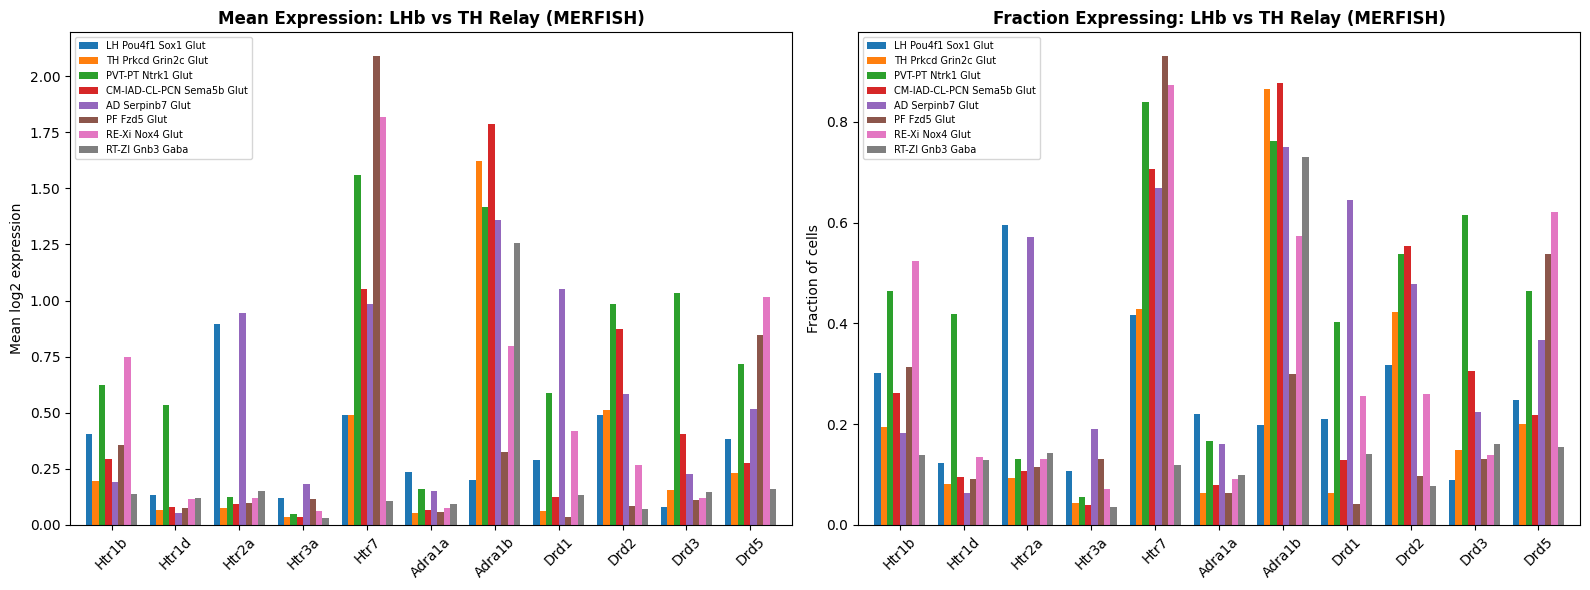

Saved: xregion_LHb_vs_TH_relay.png


In [7]:
# Grouped bar chart: LHb vs selected TH types
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Mean expression
comp_mean.T.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Mean Expression: LHb vs TH Relay (MERFISH)', fontweight='bold')
axes[0].set_ylabel('Mean log2 expression')
axes[0].set_xlabel('')
axes[0].legend(fontsize=7, loc='upper left', bbox_to_anchor=(0, 1.0))
axes[0].tick_params(axis='x', rotation=45)

# Fraction expressing
comp_frac.T.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Fraction Expressing: LHb vs TH Relay (MERFISH)', fontweight='bold')
axes[1].set_ylabel('Fraction of cells')
axes[1].set_xlabel('')
axes[1].legend(fontsize=7, loc='upper left', bbox_to_anchor=(0, 1.0))
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('xregion_LHb_vs_TH_relay.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: xregion_LHb_vs_TH_relay.png')

## 4. CLA Excitatory vs TH Excitatory (10x — Full 28 Genes)

Compare claustrum-specific excitatory neurons with thalamic relay neurons
using the full 28-gene panel.

In [8]:
all_28_genes = ['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a', 'Htr2b', 'Htr2c',
                'Htr3a', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7',
                'Adra1a', 'Adra1b', 'Adra1d', 'Adra2a', 'Adra2b', 'Adra2c',
                'Adrb1', 'Adrb2', 'Adrb3',
                'Drd1', 'Drd2', 'Drd3', 'Drd4', 'Drd5']

# Only use genes present in both datasets
available_28 = [g for g in all_28_genes if g in th_10x_expr.columns and g in cla_10x_expr.columns]

# CLA excitatory subclasses
cla_excit_keywords = ['CLA', 'EP-CLA', 'CLA-EPd']
cla_excit_mask = cla_10x_meta['subclass_short'].apply(
    lambda x: any(kw in x for kw in cla_excit_keywords) and 'Glut' in x)

# TH glutamatergic subclasses (major ones)
th_glut_keywords = ['TH ', 'PVT', 'MH ', 'LH ']
th_glut_mask = th_10x_meta['subclass_short'].apply(
    lambda x: any(x.startswith(kw) for kw in th_glut_keywords) and 'Glut' in x)

# Compute per-subclass stats for excitatory types
def compute_excit_stats(expr_df, meta_df, mask, genes):
    common = expr_df.index.intersection(meta_df.index)
    expr = expr_df.loc[common, genes].copy()
    meta = meta_df.loc[common].copy()
    mask_aligned = mask.reindex(common).fillna(False)
    expr_filt = expr[mask_aligned]
    meta_filt = meta[mask_aligned]
    expr_filt['subclass'] = meta_filt['subclass_short'].values
    
    sc_counts = expr_filt.groupby('subclass').size()
    valid = sc_counts[sc_counts >= 50].index
    expr_filt = expr_filt[expr_filt['subclass'].isin(valid)]
    
    mean_e = expr_filt.groupby('subclass')[genes].mean()
    frac_e = expr_filt.groupby('subclass')[genes].apply(lambda x: (x > 0).mean())
    return mean_e, frac_e, sc_counts[valid]

cla_e_mean, cla_e_frac, cla_e_counts = compute_excit_stats(
    cla_10x_expr, cla_10x_meta, cla_excit_mask, available_28)
th_e_mean, th_e_frac, th_e_counts = compute_excit_stats(
    th_10x_expr, th_10x_meta, th_glut_mask, available_28)

print('CLA excitatory (10x):')
for sc, n in cla_e_counts.items():
    print(f'  {sc}: {n:,} cells')

print('\nTH glutamatergic (10x):')
for sc, n in th_e_counts.items():
    print(f'  {sc}: {n:,} cells')

/tmp/ipykernel_2583/429262505.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expr_filt['subclass'] = meta_filt['subclass_short'].values


CLA excitatory (10x):
  CLA-EPd-CTX Car3 Glut: 4,022 cells
  IT EP-CLA Glut: 14,775 cells

TH glutamatergic (10x):
  LH Pou4f1 Sox1 Glut: 2,754 cells
  MH Tac2 Glut: 7,972 cells
  PVT-PT Ntrk1 Glut: 9,854 cells
  TH Prkcd Grin2c Glut: 68,125 cells


/tmp/ipykernel_2583/429262505.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expr_filt['subclass'] = meta_filt['subclass_short'].values


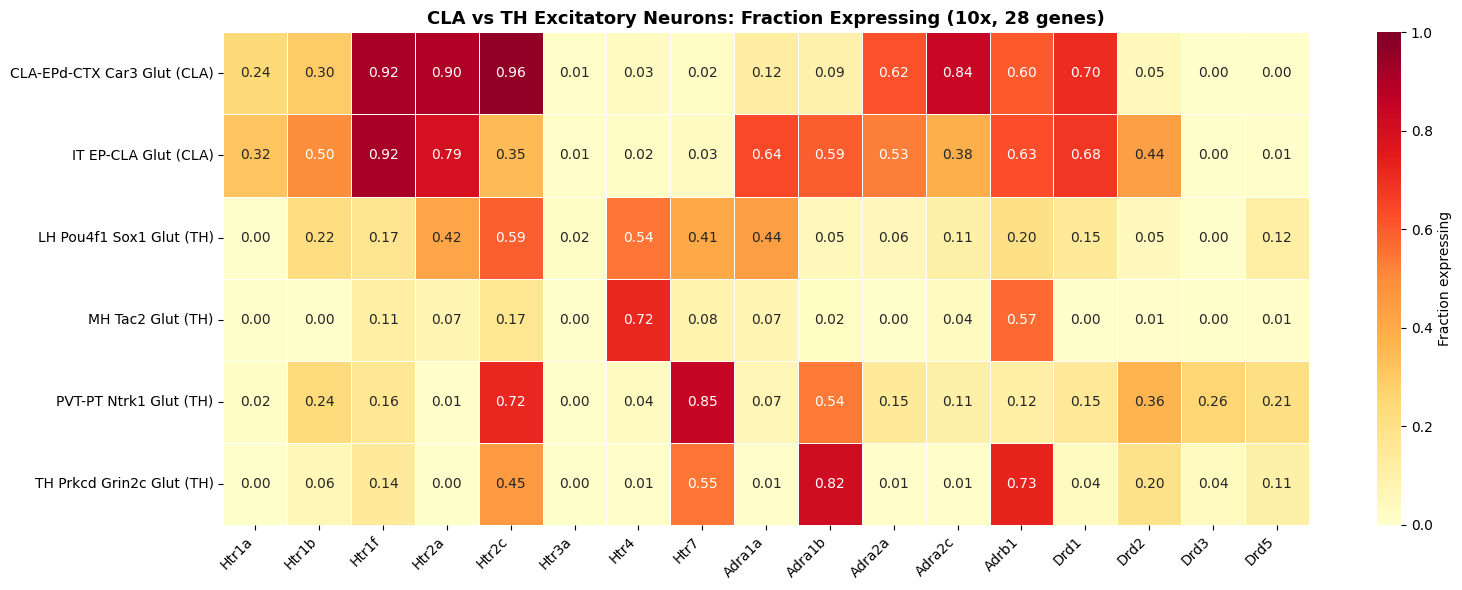

Saved: xregion_CLA_vs_TH_excitatory.png


In [9]:
# Combined heatmap: CLA excitatory + TH glutamatergic
combined_frac = pd.concat([
    cla_e_frac.assign(region='CLA'),
    th_e_frac.assign(region='TH')
])
combined_frac['label'] = combined_frac.apply(
    lambda r: f"{r.name} ({r['region']})", axis=1)
combined_frac.set_index('label', inplace=True)
combined_frac.drop('region', axis=1, inplace=True)

# Select subset of most informative genes
key_genes = ['Htr1a', 'Htr1b', 'Htr1f', 'Htr2a', 'Htr2c', 'Htr3a', 'Htr4', 'Htr7',
             'Adra1a', 'Adra1b', 'Adra2a', 'Adra2c', 'Adrb1',
             'Drd1', 'Drd2', 'Drd3', 'Drd5']
key_genes = [g for g in key_genes if g in combined_frac.columns]

fig, ax = plt.subplots(figsize=(16, max(6, len(combined_frac) * 0.5)))
sns.heatmap(combined_frac[key_genes], annot=True, fmt='.2f', cmap='YlOrRd',
            ax=ax, linewidths=0.5, vmin=0, vmax=1,
            cbar_kws={'label': 'Fraction expressing'})
ax.set_title('CLA vs TH Excitatory Neurons: Fraction Expressing (10x, 28 genes)',
             fontweight='bold', fontsize=13)
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig('xregion_CLA_vs_TH_excitatory.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: xregion_CLA_vs_TH_excitatory.png')

## 5. Shared Glia/Non-Neuronal Comparison (MERFISH)

Non-neuronal cell types (astrocytes, oligodendrocytes, OPCs, microglia, endothelial)
appear across all three regions. Compare their receptor profiles.

In [10]:
# Identify shared non-neuronal subclasses
nn_suffix = ' NN'  # Non-neuronal subclasses end with NN

def get_nn_stats(expr_df, meta_df, genes, min_cells=20):
    common = expr_df.index.intersection(meta_df.index)
    expr = expr_df.loc[common, genes].copy()
    meta = meta_df.loc[common].copy()
    nn_mask = meta['subclass_short'].str.endswith(nn_suffix)
    expr_nn = expr[nn_mask].copy()
    meta_nn = meta[nn_mask].copy()
    expr_nn['subclass'] = meta_nn['subclass_short'].values
    
    sc_counts = expr_nn.groupby('subclass').size()
    valid = sc_counts[sc_counts >= min_cells].index
    expr_nn = expr_nn[expr_nn['subclass'].isin(valid)]
    
    mean_e = expr_nn.groupby('subclass')[genes].mean()
    frac_e = expr_nn.groupby('subclass')[genes].apply(lambda x: (x > 0).mean())
    return mean_e, frac_e

th_nn_mean, th_nn_frac = get_nn_stats(th_mer_expr, th_mer_meta, shared_genes)
cla_nn_mean, cla_nn_frac = get_nn_stats(cla_mer_expr, cla_mer_meta, shared_genes)
lhb_nn_mean, lhb_nn_frac = get_nn_stats(lhb_mer_expr, lhb_mer_meta, shared_genes)

# Find shared types
shared_nn = sorted(set(th_nn_frac.index) & set(cla_nn_frac.index) & set(lhb_nn_frac.index))
print(f'Non-neuronal types shared across all 3 regions ({len(shared_nn)}):')
for sc in shared_nn:
    print(f'  {sc}')

if len(shared_nn) == 0:
    # Try pairwise
    shared_th_cla = sorted(set(th_nn_frac.index) & set(cla_nn_frac.index))
    print(f'\nNon-neuronal types shared TH-CLA ({len(shared_th_cla)}): {shared_th_cla}')
    shared_nn = shared_th_cla

Non-neuronal types shared across all 3 regions (0):

Non-neuronal types shared TH-CLA (2): ['Astro-TE NN', 'Microglia NN']


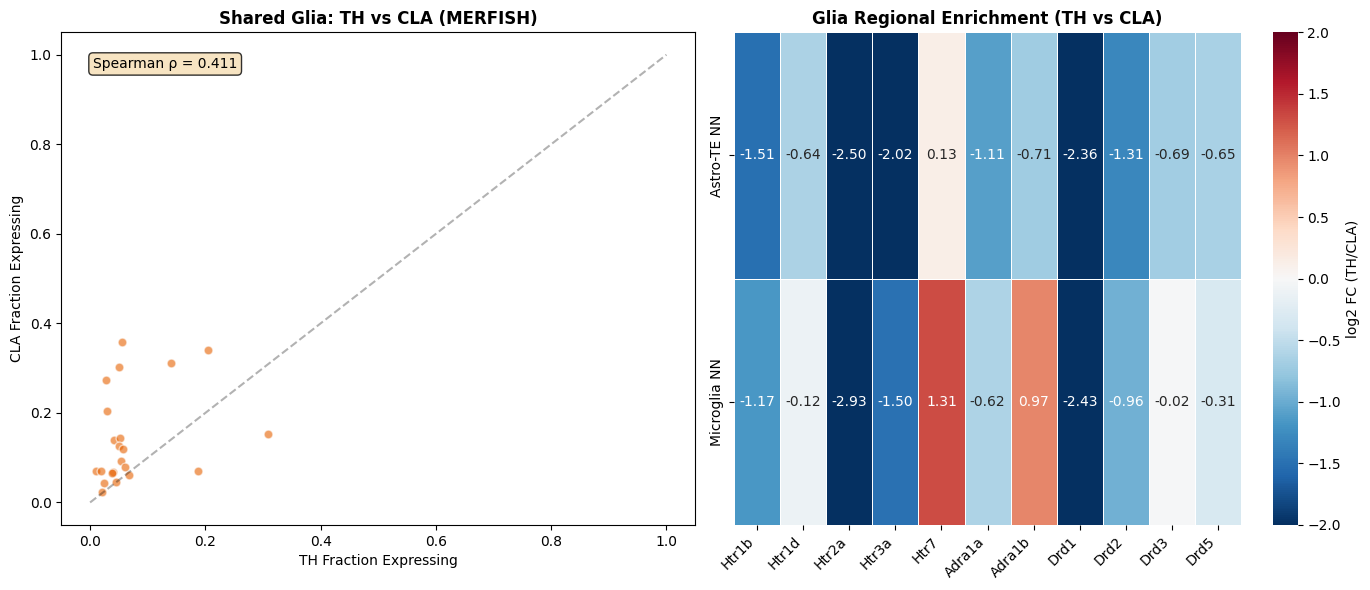

Saved: xregion_glia_TH_vs_CLA.png


In [11]:
# Cross-region scatter for shared glia (TH vs CLA MERFISH)
if len(shared_nn) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # TH vs CLA glia - mean expression
    th_vals = th_nn_frac.loc[shared_nn].values.flatten()
    cla_vals = cla_nn_frac.loc[shared_nn].values.flatten()
    
    axes[0].scatter(th_vals, cla_vals, alpha=0.6, s=40, c='#e66101', edgecolors='white')
    r_sp, _ = stats.spearmanr(th_vals, cla_vals)
    axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3)
    axes[0].text(0.05, 0.95, f'Spearman \u03c1 = {r_sp:.3f}',
                transform=axes[0].transAxes, va='top', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    axes[0].set_xlabel('TH Fraction Expressing')
    axes[0].set_ylabel('CLA Fraction Expressing')
    axes[0].set_title('Shared Glia: TH vs CLA (MERFISH)', fontweight='bold')
    
    # Enrichment heatmap
    pseudocount = 0.01
    glia_fc = np.log2((th_nn_frac.loc[shared_nn] + pseudocount) / 
                       (cla_nn_frac.loc[shared_nn] + pseudocount))
    sns.heatmap(glia_fc, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                ax=axes[1], linewidths=0.5, vmin=-2, vmax=2,
                cbar_kws={'label': 'log2 FC (TH/CLA)'})
    axes[1].set_title('Glia Regional Enrichment (TH vs CLA)', fontweight='bold')
    axes[1].set_ylabel('')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('xregion_glia_TH_vs_CLA.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: xregion_glia_TH_vs_CLA.png')
else:
    print('Not enough shared non-neuronal types for comparison')

## 6. Summary: Region-Distinguishing Receptor Signatures

Overall neuronal receptor profiles (MERFISH):

Fraction expressing:


,"TH (n=28,555)","CLA (n=7,668)","LHb (n=1,043)"
Htr1b,0.274,0.506,0.354
Htr1d,0.136,0.153,0.120
Htr2a,0.139,0.884,0.539
Htr3a,0.061,0.215,0.097
Htr7,0.515,0.154,0.414
Adra1a,0.093,0.249,0.237
Adra1b,0.717,0.531,0.226
Drd1,0.172,0.862,0.203
Drd2,0.324,0.373,0.292
Drd3,0.223,0.137,0.089



Mean expression:


,"TH (n=28,555)","CLA (n=7,668)","LHb (n=1,043)"
Htr1b,0.330,0.803,0.519
Htr1d,0.137,0.171,0.126
Htr2a,0.145,2.465,0.794
Htr3a,0.053,0.259,0.106
Htr7,0.852,0.153,0.491
Adra1a,0.084,0.290,0.256
Adra1b,1.263,0.808,0.255
Drd1,0.217,2.057,0.273
Drd2,0.442,0.593,0.444
Drd3,0.280,0.125,0.082


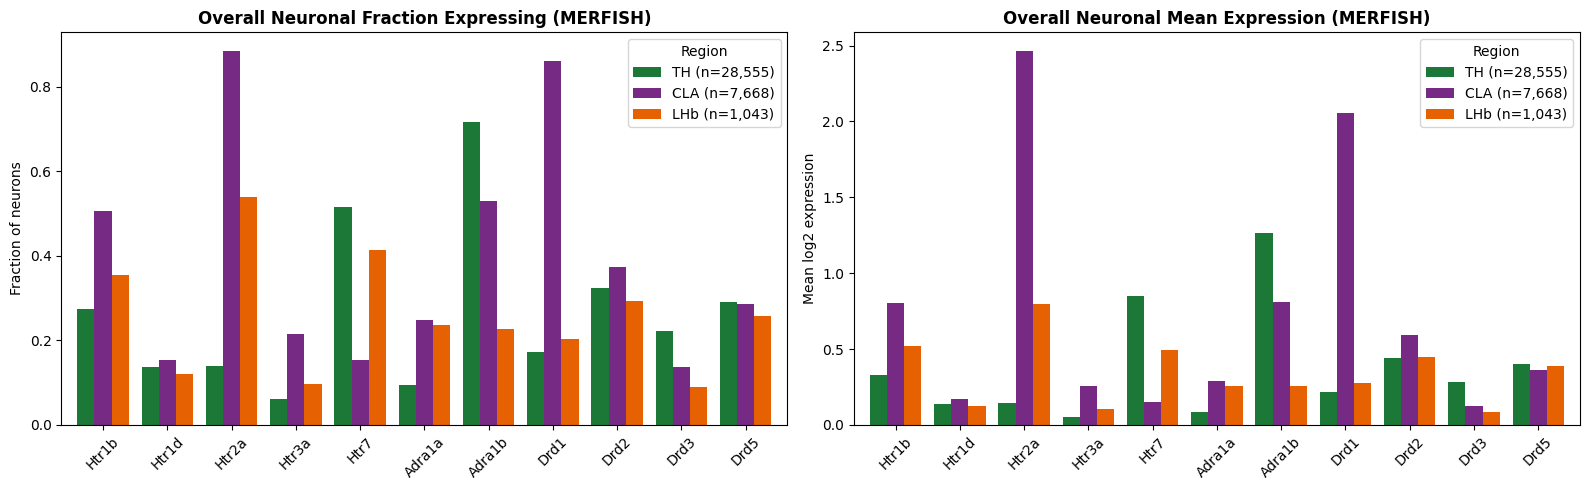

Saved: xregion_overall_profiles.png


In [12]:
# Compute overall neuronal receptor profile per region (MERFISH)
def region_neuronal_profile(expr_df, meta_df, genes):
    common = expr_df.index.intersection(meta_df.index)
    expr = expr_df.loc[common, genes].copy()
    meta = meta_df.loc[common].copy()
    neuronal = ~meta['subclass_short'].str.endswith(' NN')
    expr_n = expr[neuronal]
    return expr_n.mean(), (expr_n > 0).mean(), neuronal.sum()

th_profile_mean, th_profile_frac, th_n = region_neuronal_profile(th_mer_expr, th_mer_meta, shared_genes)
cla_profile_mean, cla_profile_frac, cla_n = region_neuronal_profile(cla_mer_expr, cla_mer_meta, shared_genes)
lhb_profile_mean, lhb_profile_frac, lhb_n = region_neuronal_profile(lhb_mer_expr, lhb_mer_meta, shared_genes)

profiles_frac = pd.DataFrame({
    f'TH (n={th_n:,})': th_profile_frac,
    f'CLA (n={cla_n:,})': cla_profile_frac,
    f'LHb (n={lhb_n:,})': lhb_profile_frac
})

profiles_mean = pd.DataFrame({
    f'TH (n={th_n:,})': th_profile_mean,
    f'CLA (n={cla_n:,})': cla_profile_mean,
    f'LHb (n={lhb_n:,})': lhb_profile_mean
})

print('Overall neuronal receptor profiles (MERFISH):')
print('\nFraction expressing:')
display(profiles_frac.round(3))
print('\nMean expression:')
display(profiles_mean.round(3))

# Bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

profiles_frac.plot(kind='bar', ax=axes[0], width=0.8, color=['#1b7837', '#762a83', '#e66101'])
axes[0].set_title('Overall Neuronal Fraction Expressing (MERFISH)', fontweight='bold')
axes[0].set_ylabel('Fraction of neurons')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Region')

profiles_mean.plot(kind='bar', ax=axes[1], width=0.8, color=['#1b7837', '#762a83', '#e66101'])
axes[1].set_title('Overall Neuronal Mean Expression (MERFISH)', fontweight='bold')
axes[1].set_ylabel('Mean log2 expression')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Region')

plt.tight_layout()
plt.savefig('xregion_overall_profiles.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: xregion_overall_profiles.png')

In [13]:
# Pairwise correlations between regional profiles
regions = profiles_frac.columns.tolist()
print('Pairwise Spearman correlations (fraction expressing):')
for i in range(len(regions)):
    for j in range(i+1, len(regions)):
        r, p = stats.spearmanr(profiles_frac.iloc[:, i], profiles_frac.iloc[:, j])
        print(f'  {regions[i]} vs {regions[j]}: rho = {r:.3f} (p = {p:.4f})')

print('\nPairwise Spearman correlations (mean expression):')
for i in range(len(regions)):
    for j in range(i+1, len(regions)):
        r, p = stats.spearmanr(profiles_mean.iloc[:, i], profiles_mean.iloc[:, j])
        print(f'  {regions[i]} vs {regions[j]}: rho = {r:.3f} (p = {p:.4f})')

Pairwise Spearman correlations (fraction expressing):
  TH (n=28,555) vs CLA (n=7,668): rho = 0.182 (p = 0.5926)
  TH (n=28,555) vs LHb (n=1,043): rho = 0.391 (p = 0.2345)
  CLA (n=7,668) vs LHb (n=1,043): rho = 0.500 (p = 0.1173)

Pairwise Spearman correlations (mean expression):
  TH (n=28,555) vs CLA (n=7,668): rho = 0.118 (p = 0.7293)
  TH (n=28,555) vs LHb (n=1,043): rho = 0.336 (p = 0.3118)
  CLA (n=7,668) vs LHb (n=1,043): rho = 0.545 (p = 0.0827)


In [14]:
# Save all cross-region data
profiles_frac.to_csv('xregion_neuronal_profiles_frac.csv')
profiles_mean.to_csv('xregion_neuronal_profiles_mean.csv')
group_mean.to_csv('xregion_thalamic_nucleus_mean.csv')
group_frac.to_csv('xregion_thalamic_nucleus_frac.csv')
log2fc.to_csv('xregion_thalamic_enrichment.csv')
print('All cross-region CSVs saved.')

All cross-region CSVs saved.
